## Part A:  Deep Learning for Tabular Data

*Markdown formats: All tables and images will be aligned to the left. (Do not remove this code)*

In [1]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<hr style="height:1px;border:none;color:#333;background-color:#333;" />

**Task Description**

1. Organise the project structure, get data and run the notebook.
2. Experiment with various MLP architectures and size of its layers.
3. Experiment with dropout layers and their dropout rates.
4. Experiment with layer activation functions (e.g. sigmoid, tanh, elu or relu).
5. Experiment with different optimisers (e.g. SGD, RMSprop, Adam, Adamax, Nadam)
6. Report and tabulate your experimental results.

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Experiments Report](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

*Load all required Python libraries (e.g. pandas, tensorflow, keras).*

In [3]:
from __future__ import print_function
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import time

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Nadam, RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv1D 
from keras.layers import LeakyReLU
from tensorflow.python.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Define the function to plot the training history, i.e. the Mean Absolute Error and Loss (Mean Squared Error), which were both defined at the time of model compilation**

In [7]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

**Specify Keras callbacks which allow additional functionality while the model is being fitted. Using ***EarlyStopping*** to stops fitting when no improvement.**


In [1]:
from tensorflow.keras.callbacks import EarlyStopping

keras_callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

*Load data from file and carry out necessary preprocessing.*

In [9]:
data_PartA = pd.read_csv('/content/drive/MyDrive/MIS780/A2/MIS780A2-DataSets/PartA-SmartHomeEnergyConsumption.csv')      
data_PartA.set_axis(['gen', 'Dishwasher', 'Furnace1', 'Furnace2', 'Home_office', 'Fridge', 'Wine_cellar', 'Garage_door', 'Kitchen12',
               'Kitchen14', 'Kitchen38', 'Barn', 'Well', 'Microwave', 'Living_room', 'Solar', 'temperature', 'Total_Consuption'], axis = 1, inplace = True)  
data_PartA.index.name = 'ID'
print('Number of records read: ', data_PartA.size)
data_PartA.index = data_PartA.index + 1
data_PartA.head(10)

Number of records read:  539964


,gen,Dishwasher,Furnace1,Furnace2,Home_office,Fridge,Wine_cellar,Garage_door,Kitchen12,Kitchen14,Kitchen38,Barn,Well,Microwave,Living_room,Solar,temperature,Total_Consuption
ID,,,,,,,,,,,,,,,,,,
1,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,0.932833
2,0.003467,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,0.934333
3,0.003467,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,0.931817
4,0.003483,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,1.022050
5,0.003467,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,1.139400
6,0.003433,0.000283,0.503250,0.063667,0.447033,0.122300,0.006717,0.012433,0.000483,0.000567,0.000000,0.031450,0.001017,0.004067,0.001583,0.003433,36.14,1.391867
7,0.003450,0.000283,0.499400,0.063717,0.443267,0.122050,0.006733,0.012417,0.000517,0.000550,0.000000,0.031550,0.001033,0.004117,0.001533,0.003450,36.14,1.366217
8,0.003417,0.000250,0.477867,0.178633,0.444283,0.121800,0.006783,0.012550,0.000483,0.000450,0.000000,0.031733,0.001033,0.004200,0.001550,0.003417,36.14,1.431900
9,0.003417,0.000183,0.447650,0.365700,0.441467,0.121617,0.006950,0.012717,0.000467,0.000300,0.000017,0.031767,0.001017,0.004200,0.001567,0.003417,36.14,1.627300


In [10]:
#Observe the data type of columns
data_PartA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29998 entries, 1 to 29998
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gen               29998 non-null  float64
 1   Dishwasher        29998 non-null  float64
 2   Furnace1          29998 non-null  float64
 3   Furnace2          29998 non-null  float64
 4   Home_office       29998 non-null  float64
 5   Fridge            29998 non-null  float64
 6   Wine_cellar       29998 non-null  float64
 7   Garage_door       29998 non-null  float64
 8   Kitchen12         29998 non-null  float64
 9   Kitchen14         29998 non-null  float64
 10  Kitchen38         29998 non-null  float64
 11  Barn              29998 non-null  float64
 12  Well              29998 non-null  float64
 13  Microwave         29998 non-null  float64
 14  Living_room       29998 non-null  float64
 15  Solar             29998 non-null  float64
 16  temperature       29998 non-null  float6

In [11]:
# Identification of missing values
missing_PartA = data_PartA.isnull().sum()
missing_PartA

gen                 0
Dishwasher          0
Furnace1            0
Furnace2            0
Home_office         0
Fridge              0
Wine_cellar         0
Garage_door         0
Kitchen12           0
Kitchen14           0
Kitchen38           0
Barn                0
Well                0
Microwave           0
Living_room         0
Solar               0
temperature         0
Total_Consuption    0
dtype: int64

In [12]:
#Data Description
data_PartA.describe()

,gen,Dishwasher,Furnace1,Furnace2,Home_office,Fridge,Wine_cellar,Garage_door,Kitchen12,Kitchen14,Kitchen38,Barn,Well,Microwave,Living_room,Solar,temperature,Total_Consuption
count,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000
mean,0.056453,0.038770,0.232167,0.240812,0.101068,0.056384,0.018790,0.013682,0.001403,0.008986,0.000010,0.065703,0.017443,0.009423,0.048360,0.056453,27.108708,1.079720
std,0.115127,0.212522,0.221758,0.252538,0.115567,0.072355,0.034726,0.009739,0.019662,0.084576,0.000010,0.150328,0.145153,0.080788,0.108222,0.115127,9.414269,0.685901
min,0.000000,0.000000,0.002433,0.002017,0.002467,0.000133,0.000217,0.000467,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.910000,0.000033
25%,0.003067,0.000017,0.021617,0.064600,0.042067,0.005000,0.006800,0.012450,0.000433,0.000050,0.000000,0.029033,0.001000,0.004000,0.001500,0.003067,20.260000,0.598583
50%,0.003350,0.000067,0.102017,0.070733,0.049433,0.005333,0.007100,0.012817,0.000633,0.000133,0.000017,0.030117,0.001000,0.004083,0.001600,0.003350,27.540000,0.956958
75%,0.032375,0.000233,0.479917,0.567029,0.108700,0.121400,0.007400,0.013050,0.000733,0.000300,0.000017,0.031650,0.001017,0.004200,0.001700,0.032375,34.690000,1.434775
max,0.554950,1.378650,1.915517,0.775417,0.913317,0.851267,0.229633,0.341417,0.906283,1.612117,0.000067,6.327833,1.614650,1.871750,0.348700,0.554950,55.880000,7.378917


*Split data for training and validation (e.g. 0.7/0.3).*

In [13]:
train_size, valid_size, test_size = (0.7, 0.3, 0.0)
PartA_train, PartA_valid = train_test_split(data_PartA, test_size = valid_size, random_state=2020)

**Set label column for the dataset**

In [14]:
#Set name of label column
label_col = 'Total_Consuption'

In [15]:
#Prepare data to build model
PartA_y_train = PartA_train[[label_col]]
PartA_x_train = PartA_train.drop(label_col, axis=1)
PartA_y_valid = PartA_valid[[label_col]]
PartA_x_valid = PartA_valid.drop(label_col, axis=1)

print('Size of training set: ', len(PartA_x_train))
print('Size of validation set: ', len(PartA_x_valid))

Size of training set:  20998
Size of validation set:  9000


In [16]:
#Print 10 first rows in valid datadet without label column
PartA_x_valid.head(10)

,gen,Dishwasher,Furnace1,Furnace2,Home_office,Fridge,Wine_cellar,Garage_door,Kitchen12,Kitchen14,Kitchen38,Barn,Well,Microwave,Living_room,Solar,temperature
ID,,,,,,,,,,,,,,,,,
14265,0.003367,0.115167,0.019917,0.063250,0.474850,0.033100,0.010800,0.012700,0.000667,0.000300,0.000017,0.119833,0.001133,0.007167,0.001650,0.003367,30.76
14538,0.003400,0.000067,0.482567,0.063867,0.042517,0.118817,0.006500,0.012383,0.000467,0.000200,0.000000,0.035417,0.001017,0.004000,0.001550,0.003400,29.19
17236,0.003700,0.000017,0.020267,0.064517,0.042300,0.005167,0.006983,0.012933,0.000817,0.000033,0.000000,0.030800,0.001033,0.004000,0.001617,0.003700,22.07
12877,0.003350,0.000000,0.020917,0.065083,0.433600,0.004783,0.006817,0.013233,0.000717,0.000217,0.000000,0.030033,0.001000,0.004000,0.001550,0.003350,39.39
24127,0.003400,0.000050,0.478383,0.654550,0.068867,0.123233,0.121733,0.012617,0.000400,0.000000,0.000017,0.482917,0.001000,0.004000,0.340083,0.003400,20.53
13053,0.003350,0.000033,0.021083,0.269717,0.042217,0.005250,0.007050,0.013317,0.000683,0.000083,0.000000,0.030067,0.001000,0.004000,0.001617,0.003350,44.92
2969,0.003050,0.000367,0.021650,0.526833,0.042033,0.137050,0.117633,0.013417,0.000350,0.000317,0.000000,0.031650,0.001017,0.004250,0.001617,0.003050,29.25
27874,0.038517,0.000000,0.070017,0.066983,0.039183,0.005450,0.007267,0.012950,0.000683,0.000033,0.000017,0.028683,0.000833,0.003850,0.001150,0.038517,22.65
1083,0.003567,0.000000,0.019983,0.062000,0.042400,0.106050,0.007283,0.012500,0.000667,0.000117,0.000017,0.373683,0.001050,0.004000,0.099333,0.003567,33.87


**Next, create a scaling model using training set and use it to scale both training and validation data.**

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(PartA_x_train)
PartA_x_train = pd.DataFrame(scaler.transform(PartA_x_train), 
                            columns = PartA_x_train.columns, index = PartA_x_train.index)
PartA_x_valid = pd.DataFrame(scaler.transform(PartA_x_valid), 
                            columns = PartA_x_valid.columns, index = PartA_x_valid.index)

print('X train min =', round(PartA_x_train.min().min(),4), '; max =', round(PartA_x_train.max().max(), 4))
print('X valid min =', round(PartA_x_valid.min().min(),4), '; max =', round(PartA_x_valid.max().max(), 4))

X train min = 0.0 ; max = 1.0
X valid min = 0.0 ; max = 1.0922


In [18]:
#Set plot = True
plot = True

**Convert pandas data frames to `np` arrays.**

In [19]:
arr_x_train = np.array(PartA_x_train)
arr_y_train = np.array(PartA_y_train)
arr_x_valid = np.array(PartA_x_valid)
arr_y_valid = np.array(PartA_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

Training shape: (20998, 17)
Training samples:  20998
Validation samples:  9000


<a id = "cell_model"></a>
## 3. Model Construction

*For all models, use mean_squared_error as the loss function, and set the number of epochs to be 500.*

**The model 1 has 5 dense layers, with SGD optimizer**


In [20]:
#Model 1
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(10))
    t_model.add(Dense(1, activation='sigmoid'))
    t_model.add(Dense(y_size))
    t_model.compile(loss='mean_squared_error', 
                    optimizer='sgd', 
                    metrics=[metrics.mae])
    return(t_model)

In [21]:
### build model
model1 = basic_model_1(arr_x_train.shape[1], arr_y_train.shape[1])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 7,373
Trainable params: 7,373
Non-trainable params: 0
_________________________________________________________________


* dense: (17 input predictors + 1 bias)x 100 hidden nodes
* dense_1: (100 hidden nodes previous layer + 1 bias)x 50 hidden nodes
* dense_2: (50 hidden nodes previous layer + 1 bias)x 10 hidden node
* dense_3: (10 hidden nodes previous layer + 1 bias)x 1 output node 
* dense_4: (1 hidden nodes previous layer + 1 bias)x 1 output node

*The first layer has 100 hidden nodes with tanh activation*

*The second layer has 50 hidden nodes with relu activation*

*The third layer has 10 output nodes.*

*Then the fourth layer has 1 hidden node with sigmoid activation and the last layer has 1 output node.*

*The model needs 7,373 params to train model.*


**The model 2 has 4 dense layers, and three time uses 40% dropouts, with Adam optimizer**

In [22]:
#Model 2
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.4))
    t_model.add(Dense(50))
    t_model.add(Dropout(0.4))
    t_model.add(Dense(10))
    t_model.add(Dropout(0.4))
    t_model.add(Dense(y_size))
    t_model.compile(loss='mean_squared_error', 
                    optimizer='adam', 
                    metrics=[metrics.mae])
    return(t_model)

In [23]:
### build model
model2 = basic_model_2(arr_x_train.shape[1], arr_y_train.shape[1])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1800      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

* dense_5: (17 input predictors + 1 bias)x 100 hidden nodes
* dense_6: (100 hidden nodes previous layer + 1 bias)x 50 hidden nodes
* dense_7: (50 hidden nodes previous layers + 1 bias)x 10 hidden nodes
* dense_8: (10 hidden nodes previous layers + 1 bias)x 1 output node

*The first layer has 100 hidden nodes with tanh activation and normal kernal.*

*Next, using three times 40% dropout before each  second layer with 50 hidden nodes, third layer with 10 hidden nodes, and fourth layer has 1 output node.*

*The reason for using dropout to prevent overtraining.*

*The model need 7,371 params to train model.*

**The model 3 has 5 dense layers, and 40% dropouts, with RMSProp optimizer**

In [24]:
#Model 3
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.4))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(10, activation="relu"))
    t_model.add(Dense(1))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07, decay=0.0),
        metrics=[metrics.mae])
    return(t_model)

In [25]:
### build model
model3 = basic_model_3(arr_x_train.shape[1], arr_y_train.shape[1])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               1800      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 2         
Total params: 7,373
Trainable params: 7,373
Non-trainable params: 0
____________________________________________________

* dense_9: (17 input predictors + 1 bias)x 100 hidden nodes
* dense_10: (100 hidden nodes previous layer + 1 bias)x 50 hidden nodes
* dense_11: (50 hidden nodes previous layer + 1 bias)x 50 hidden nodes
* dense_12: (10 hidden nodes previous layer + 1 bias)x 1 hidden node
* dense_13: (1 hidden nodes previous layer + 1 bias)x 1 output node 

*The first layer has 100 hidden nodes with tanh activation and normal kernal.*

*Next, using 40% dropout before second layer with 50 hidden node. The third layer is 50 output nodes. These layers use relu activation.*

*Then, the fourth layer has 1 hidden node. And the last layer only has 1 output node.*

*The model needs total 7,373 params*

**The model 4 includes 4 layers, and twice 40% dropouts with Nadam optimizer**

In [26]:
#Model 4
def basic_model_4(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(50, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.4))
    t_model.add(Dense(30, activation="relu"))
    t_model.add(Dropout(0.4))
    t_model.add(Dense(10, activation="relu"))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        metrics=[metrics.mae])
    return(t_model)

In [27]:
### build model
model4 = basic_model_4(arr_x_train.shape[1], arr_y_train.shape[1])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 50)                900       
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 30)                1530      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
____________________________________________________

* dense_14: (17 input predictors + 1 bias)x 50 hidden nodes
* dense_15: (50 hidden nodes previous layer + 1 bias)x 30 hidden nodes
* dense_16: (30 hidden nodes previous layer + 1 bias)x 10 hidden node
* dense_17: (10 hidden nodes previous layer + 1 bias)x 1 output node 

*The first layer has 50 hidden nodes with tanh activation.*

*Next, using twice 40% dropout before each second layer with 30 hidden nodes and third layer with 10 output nodes. These layers use relu activation.*

*The last layer has 1 output node.*

*The reason for using dropout to prevent overtraining.*

*The model need 2,751 params to train model.*

**The model 5 consists of 4 layers, with Adam optimizer**

In [78]:
#Model 5
def basic_model_5(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(8, activation="relu", input_shape=(x_size,)))
    t_model.add(Dense(5,))
    t_model.add(Dense(1))
    t_model.add(Dense(y_size))
    t_model.compile(loss="mean_squared_error", 
                    optimizer=Adam(),
                    metrics=[metrics.mae])
    return(t_model)

In [79]:
### build model
model5 = basic_model_5(arr_x_train.shape[1], arr_y_train.shape[1])
model5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 8)                 144       
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 45        
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 6         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 2         
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


* dense_18: (17 input predictors + 1 bias)x 8 hidden nodes
* dense_19: (10 hidden nodes previous layer + 1 bias)x 5 hidden nodes
* dense_20: (5 hidden nodes previous layer + 1 bias)x 1 hidden node
* dense_21: (1 hidden nodes previous layer + 1 bias)x 1 hidden node
* dense_128: (1 hidden nodes previous layer + 1 bias)x 1 output node 

*The first layer has 8 hidden nodes with relu activation.*

*The second layer has 5 hidden nodes.*

*The third layer has 1 hidden node.*

*And the last layer has 1 output node.*

*The model only needs 197 params to build model.*


<a id = "cell_execution"></a>
## 4. Model Execution

*This section is to provide code to fit the models. Record and plot the history of training and validation. Report the performance of the trained model on the both the training and the test sets.*<br>

**Model 1**

In [30]:
### fit model
start1 = time.process_time()
history1 = model1.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

time1 = time.process_time() - start1
#time of process
print("Time of process for model 1: ", time1)

Epoch 1/500
329/329 - 3s - loss: 0.5954 - mean_absolute_error: 0.5507 - val_loss: 0.4570 - val_mean_absolute_error: 0.4909
Epoch 2/500
329/329 - 1s - loss: 0.4336 - mean_absolute_error: 0.4739 - val_loss: 0.4249 - val_mean_absolute_error: 0.4629
Epoch 3/500
329/329 - 1s - loss: 0.3857 - mean_absolute_error: 0.4320 - val_loss: 0.3562 - val_mean_absolute_error: 0.4073
Epoch 4/500
329/329 - 1s - loss: 0.3129 - mean_absolute_error: 0.3654 - val_loss: 0.2841 - val_mean_absolute_error: 0.3430
Epoch 5/500
329/329 - 1s - loss: 0.2628 - mean_absolute_error: 0.3176 - val_loss: 0.2490 - val_mean_absolute_error: 0.3047
Epoch 6/500
329/329 - 1s - loss: 0.2384 - mean_absolute_error: 0.2940 - val_loss: 0.2317 - val_mean_absolute_error: 0.3118
Epoch 7/500
329/329 - 1s - loss: 0.2210 - mean_absolute_error: 0.2762 - val_loss: 0.2102 - val_mean_absolute_error: 0.2670
Epoch 8/500
329/329 - 1s - loss: 0.2059 - mean_absolute_error: 0.2581 - val_loss: 0.1949 - val_mean_absolute_error: 0.2479
Epoch 9/500
329/

*The time processing of model is 151s and the final validation MAE for this model was 112.*

In [31]:
### evaluate the model with mae score
train_score1 = model1.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score1 = model1.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(PartA_y_train['Total_Consuption'].mean(), 4))
print('Train MAE: ', round(train_score1[1], 4), ', Train Loss: ', round(train_score1[0], 4)) 
print('Val Mean:', round(PartA_y_valid['Total_Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score1[1], 4), ', Val Loss: ', round(valid_score1[0], 4))

Train Mean: 1.0763
Train MAE:  0.1395 , Train Loss:  0.1038
Val Mean: 1.0877
Val MAE:  0.1416 , Val Loss:  0.1084


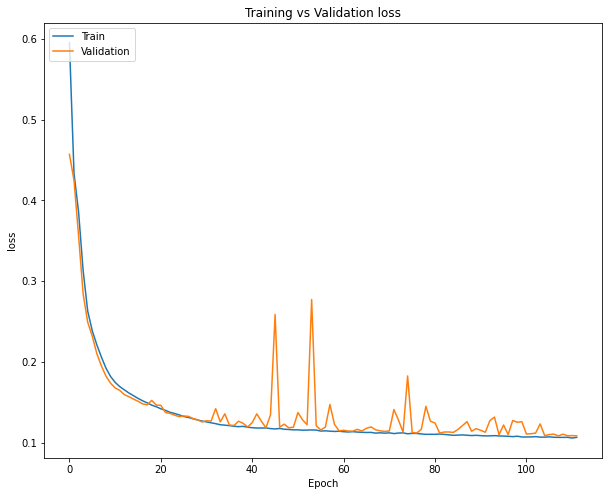

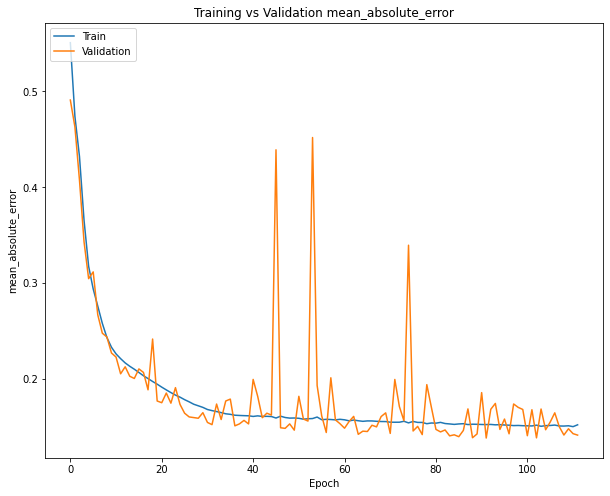

In [32]:
### plot the performance of model
hist1 = pd.DataFrame(history1.history)

plot_hist(hist1, xsize=10, ysize=8)

*The figure of Training and Validation loss shows that Validation set is too small compared with training set. Because learning curve for training loss that looks like a good fit when it decreased stability to a point. Also, a learning curve for validation loss that shows dramtic movements around the training loss.*

*Meanwhile, MAE figure shows the unstable changes between actual and predicted values of model. To be more specific, MAE of validation at some epoches is very greater than that of MAE training.*

**Model 2**

In [33]:
### fit model
start2 = time.process_time()
history2 = model2.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

time2 = time.process_time() - start2
#time of process
print("Time of process for model 2: ", time2)

Epoch 1/500
329/329 - 2s - loss: 0.3409 - mean_absolute_error: 0.3786 - val_loss: 0.1492 - val_mean_absolute_error: 0.1858
Epoch 2/500
329/329 - 1s - loss: 0.2305 - mean_absolute_error: 0.2924 - val_loss: 0.1279 - val_mean_absolute_error: 0.1651
Epoch 3/500
329/329 - 1s - loss: 0.1975 - mean_absolute_error: 0.2638 - val_loss: 0.1301 - val_mean_absolute_error: 0.1428
Epoch 4/500
329/329 - 1s - loss: 0.1812 - mean_absolute_error: 0.2473 - val_loss: 0.1237 - val_mean_absolute_error: 0.1500
Epoch 5/500
329/329 - 1s - loss: 0.1721 - mean_absolute_error: 0.2354 - val_loss: 0.1278 - val_mean_absolute_error: 0.1895
Epoch 6/500
329/329 - 1s - loss: 0.1707 - mean_absolute_error: 0.2342 - val_loss: 0.1254 - val_mean_absolute_error: 0.1576
Epoch 7/500
329/329 - 1s - loss: 0.1615 - mean_absolute_error: 0.2250 - val_loss: 0.1272 - val_mean_absolute_error: 0.1549
Epoch 8/500
329/329 - 1s - loss: 0.1581 - mean_absolute_error: 0.2227 - val_loss: 0.1217 - val_mean_absolute_error: 0.1786
Epoch 9/500
329/

*The time processing of model is 34.5s and the final validation MAE for this model was 23.*

In [34]:
### evaluate the model with mae score
train_score2 = model2.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score2 = model2.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(PartA_y_train['Total_Consuption'].mean(), 4))
print('Train MAE: ', round(train_score2[1], 4), ', Train Loss: ', round(train_score2[0], 4)) 
print('Val Mean:', round(PartA_y_valid['Total_Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score2[1], 4), ', Val Loss: ', round(valid_score2[0], 4))

Train Mean: 1.0763
Train MAE:  0.1855 , Train Loss:  0.1222
Val Mean: 1.0877
Val MAE:  0.187 , Val Loss:  0.1247


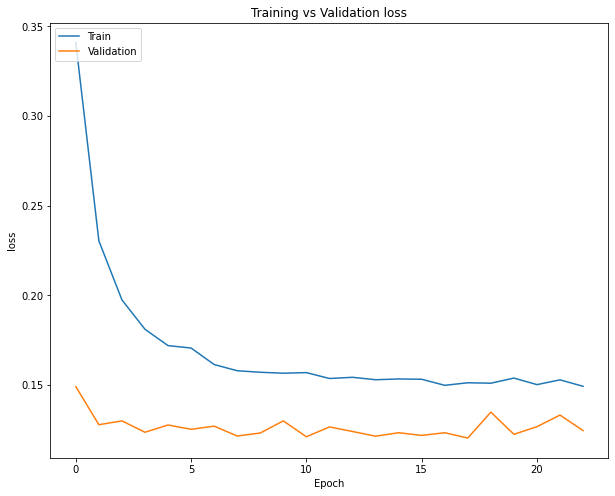

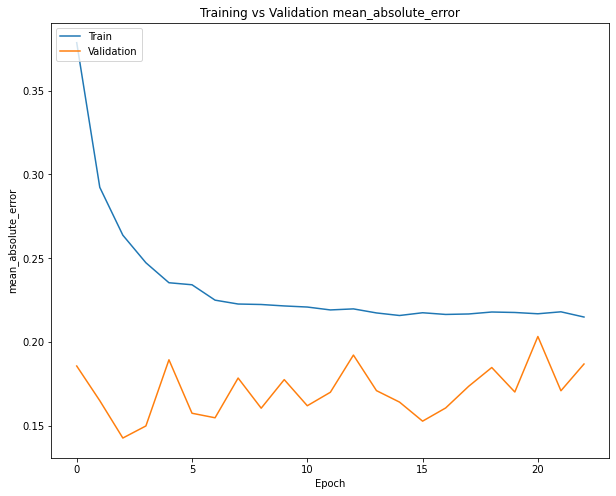

In [35]:
### plot the performance of model
hist2 = pd.DataFrame(history2.history)

plot_hist(hist2, xsize=10, ysize=8)

*The figure of Training and Validation loss shows that the validation set is simpler than training set (validation loss lower than training loss). This also means the model can predict easily the validation set compared with training set.*

*Meanwhile, the traning and validation MAE figure shows the MAE validation is consistanly lower than MAE training which also means the model maybe underfitting*

**Model 3**

In [36]:
### fit model
start3 = time.process_time()
history3 = model3.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

time3 = time.process_time() - start3
#time of process
print("Time of process for model 3: ", time3)

Epoch 1/500
329/329 - 2s - loss: 0.2242 - mean_absolute_error: 0.2700 - val_loss: 0.1612 - val_mean_absolute_error: 0.1938
Epoch 2/500
329/329 - 1s - loss: 0.1324 - mean_absolute_error: 0.1867 - val_loss: 0.1310 - val_mean_absolute_error: 0.1627
Epoch 3/500
329/329 - 1s - loss: 0.1248 - mean_absolute_error: 0.1787 - val_loss: 0.1148 - val_mean_absolute_error: 0.1603
Epoch 4/500
329/329 - 1s - loss: 0.1202 - mean_absolute_error: 0.1720 - val_loss: 0.1125 - val_mean_absolute_error: 0.1460
Epoch 5/500
329/329 - 1s - loss: 0.1194 - mean_absolute_error: 0.1684 - val_loss: 0.1130 - val_mean_absolute_error: 0.1583
Epoch 6/500
329/329 - 1s - loss: 0.1170 - mean_absolute_error: 0.1651 - val_loss: 0.1444 - val_mean_absolute_error: 0.2715
Epoch 7/500
329/329 - 1s - loss: 0.1163 - mean_absolute_error: 0.1658 - val_loss: 0.1410 - val_mean_absolute_error: 0.2573
Epoch 8/500
329/329 - 1s - loss: 0.1155 - mean_absolute_error: 0.1631 - val_loss: 0.1171 - val_mean_absolute_error: 0.1974
Epoch 9/500
329/

*The time processing of model is 133s and the final validation MAE for this model was 78.*

In [37]:
### evaluate the model with mae score
train_score3 = model3.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score3 = model3.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(PartA_y_train['Total_Consuption'].mean(), 4))
print('Train MAE: ', round(train_score3[1], 4), ', Train Loss: ', round(train_score3[0], 4)) 
print('Val Mean:', round(PartA_y_valid['Total_Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score3[1], 4), ', Val Loss: ', round(valid_score3[0], 4))

Train Mean: 1.0763
Train MAE:  0.1902 , Train Loss:  0.1058
Val Mean: 1.0877
Val MAE:  0.1925 , Val Loss:  0.1102


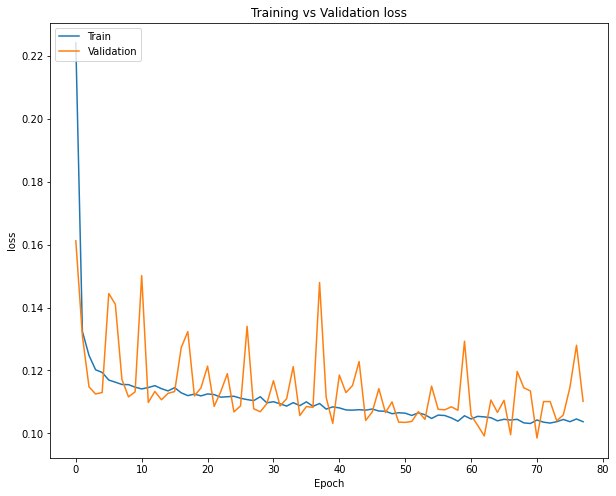

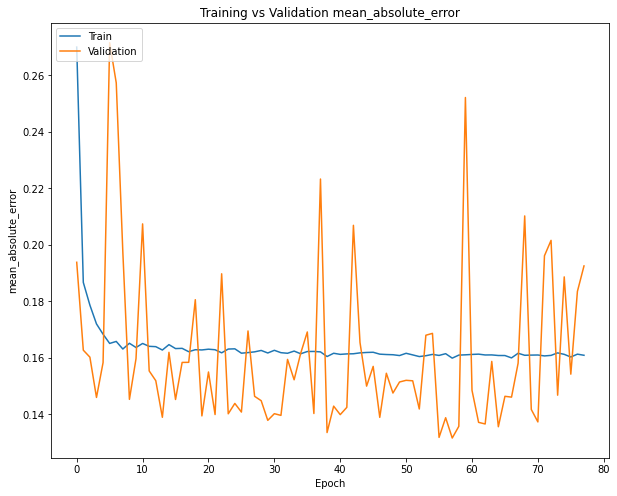

In [38]:
### plot the performance of model
hist3 = pd.DataFrame(history3.history)

plot_hist(hist3, xsize=10, ysize=8)

*The figure of Training and Validation loss shows that Validation set is too small compared with training set. Because learning curve for training loss that looks like a good fit when it decreased stability to a point. Also, a learning curve for validation loss that shows dramtic movements around the training loss.*

*Meanwhile, MAE figure shows the dramatic changes between actual and predicted values of model. To be more specific, MAE of validation at some epoches is very greater or very lower than that of MAE training, and we can see clearly the gap between these values*

**Model 4**

In [39]:
### fit model
start4 = time.process_time()
history4 = model4.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

time4  = time.process_time() - start4
#time of process
print("Time of process for model 4: ", time4)

Epoch 1/500
329/329 - 3s - loss: 0.3588 - mean_absolute_error: 0.3885 - val_loss: 0.1770 - val_mean_absolute_error: 0.2253
Epoch 2/500
329/329 - 2s - loss: 0.2012 - mean_absolute_error: 0.2722 - val_loss: 0.1420 - val_mean_absolute_error: 0.1844
Epoch 3/500
329/329 - 2s - loss: 0.1746 - mean_absolute_error: 0.2435 - val_loss: 0.1504 - val_mean_absolute_error: 0.1864
Epoch 4/500
329/329 - 1s - loss: 0.1603 - mean_absolute_error: 0.2260 - val_loss: 0.1295 - val_mean_absolute_error: 0.1679
Epoch 5/500
329/329 - 1s - loss: 0.1498 - mean_absolute_error: 0.2143 - val_loss: 0.1298 - val_mean_absolute_error: 0.1700
Epoch 6/500
329/329 - 1s - loss: 0.1441 - mean_absolute_error: 0.2086 - val_loss: 0.1287 - val_mean_absolute_error: 0.1641
Epoch 7/500
329/329 - 1s - loss: 0.1400 - mean_absolute_error: 0.2019 - val_loss: 0.1292 - val_mean_absolute_error: 0.1689
Epoch 8/500
329/329 - 2s - loss: 0.1387 - mean_absolute_error: 0.1994 - val_loss: 0.1313 - val_mean_absolute_error: 0.1584
Epoch 9/500
329/

*The time processing of model is 56s and the final validation MAE for this model was 28.*

In [40]:
### evaluate the model with mae score
train_score4 = model4.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score4 = model4.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(PartA_y_train['Total_Consuption'].mean(), 4))
print('Train MAE: ', round(train_score4[1], 4), ', Train Loss: ', round(train_score4[0], 4)) 
print('Val Mean:', round(PartA_y_valid['Total_Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score4[1], 4), ', Val Loss: ', round(valid_score4[0], 4))

Train Mean: 1.0763
Train MAE:  0.2322 , Train Loss:  0.1391
Val Mean: 1.0877
Val MAE:  0.2343 , Val Loss:  0.1419


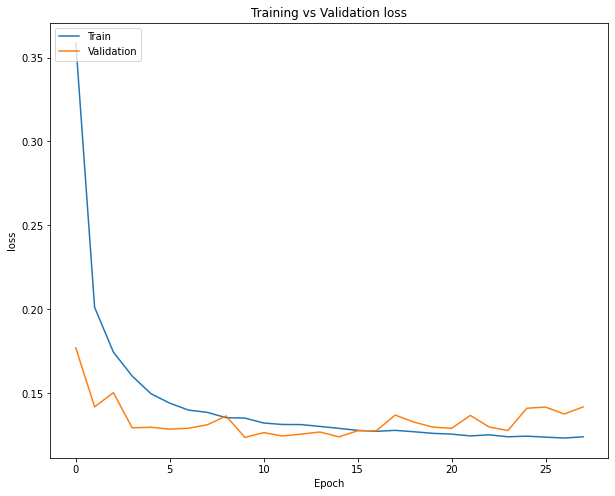

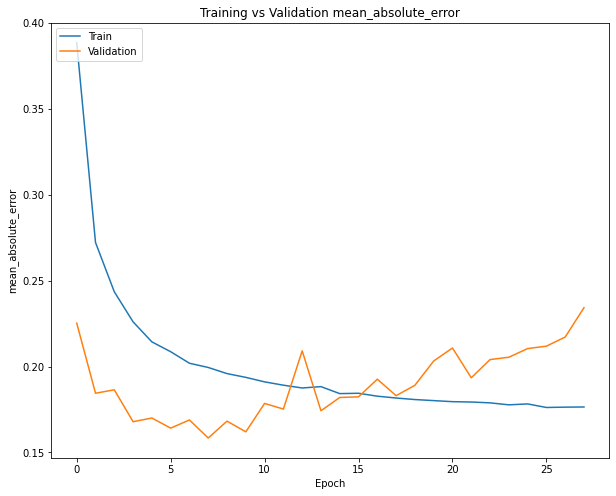

In [41]:
### plot the performance of model
hist4 = pd.DataFrame(history4.history)

plot_hist(hist4, xsize=10, ysize=8)

*Both figures show that the model is overfitting because*

    -The plot of training loss continues to decrease with experience.
    -The plot of validation loss decreases to a point and begins increasing again.

**Model 5**

In [80]:
### fit model
start5 = time.process_time()
history5 = model5.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

time5 = time.process_time() - start5
#time of process
print("Time of process for model 5: ", time5)

Epoch 1/500
329/329 - 2s - loss: 0.5203 - mean_absolute_error: 0.5012 - val_loss: 0.2147 - val_mean_absolute_error: 0.3069
Epoch 2/500
329/329 - 1s - loss: 0.1765 - mean_absolute_error: 0.2529 - val_loss: 0.1493 - val_mean_absolute_error: 0.2067
Epoch 3/500
329/329 - 1s - loss: 0.1462 - mean_absolute_error: 0.2037 - val_loss: 0.1382 - val_mean_absolute_error: 0.1958
Epoch 4/500
329/329 - 1s - loss: 0.1380 - mean_absolute_error: 0.1910 - val_loss: 0.1334 - val_mean_absolute_error: 0.1876
Epoch 5/500
329/329 - 1s - loss: 0.1328 - mean_absolute_error: 0.1841 - val_loss: 0.1302 - val_mean_absolute_error: 0.1878
Epoch 6/500
329/329 - 1s - loss: 0.1285 - mean_absolute_error: 0.1789 - val_loss: 0.1263 - val_mean_absolute_error: 0.1782
Epoch 7/500
329/329 - 1s - loss: 0.1244 - mean_absolute_error: 0.1736 - val_loss: 0.1233 - val_mean_absolute_error: 0.1750
Epoch 8/500
329/329 - 1s - loss: 0.1213 - mean_absolute_error: 0.1687 - val_loss: 0.1218 - val_mean_absolute_error: 0.1777
Epoch 9/500
329/

*The time processing of model is 60s and the final validation MAE for this model was 43.*

In [81]:
### evaluate the model with mae score
train_score5 = model5.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score5 = model5.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(PartA_y_train['Total_Consuption'].mean(), 4))
print('Train MAE: ', round(train_score5[1], 4), ', Train Loss: ', round(train_score5[0], 4)) 
print('Val Mean:', round(PartA_y_valid['Total_Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score5[1], 4), ', Val Loss: ', round(valid_score5[0], 4))

Train Mean: 1.0763
Train MAE:  0.1541 , Train Loss:  0.1155
Val Mean: 1.0877
Val MAE:  0.1556 , Val Loss:  0.1178


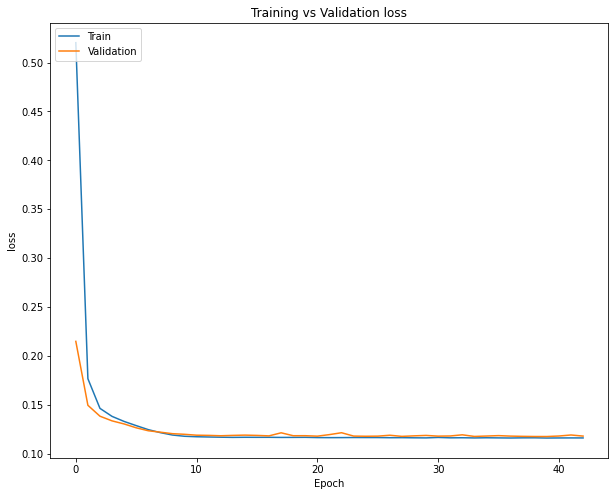

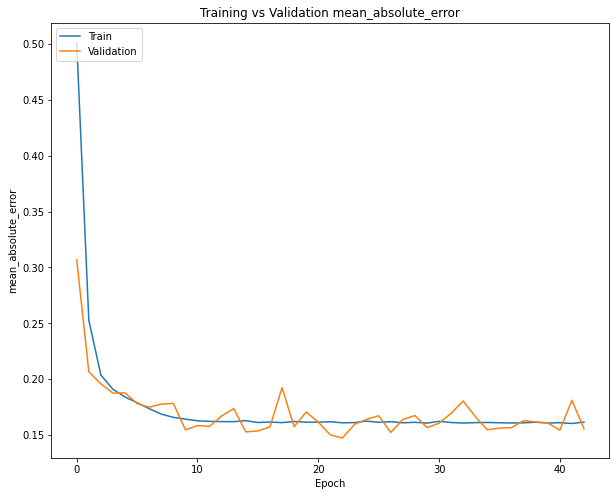

In [82]:
### plot the performance of model
hist5 = pd.DataFrame(history5.history)

plot_hist(hist5, xsize=10, ysize=8)

*The figure of Training and Validation loss shows that the model is good fit because of two reasons as below:*

    * The plot of training loss decreases to a point of stability.
    * The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

*Also, the figure of MAE training and validation reflects that the MAE validation is not consistanly higher or lower than MAE training which also means the model is not under or overfitting.*


<a id = "cell_report"></a>
## 5. Experiments Report

*Provide a summary of experimental results in the table below.*

| Model# |  Train MAE | Valid MAE |
| :-: | -: | -: |
| 1 | 0.1395    | 0.1416|   |
| 2 |0.185   | 0.187 |   |
| 3 | 0.1902   | 0.1925 |   |
| 4 | 0.2232  |  0.2343|   |
| 5 | 0.1541   |   0.1556|   |

<br>

*The time processing (with GPU) of five model as below:*


| Model# |  Time Processing(s) | Params |
| :-: | -: | -: |
| 1 | 150.987628441 | 7373  |  
| 2 | 34.48036289000001 | 7371  |   
| 3 | 132.926247616 | 7373  |   
| 4 |56.06772398999999  | 2751  |   
| 5 | 60.06723718500007 | 243  |   

*In a paragraph discuss your results. Identify the strengths and weaknesses of the selected models. Which model would you recommend as a final solution? and why?.*
<br>

MAE is used to measure accuracy of models. More precisely, this value is lower 
which also means a good model. From table of MAE summary, all models are quite good (from 0.14 to 0.23).


However, when using the plot to visulize the model performance, there are some problems. To be more specific, figures of model 1 and 3 show that the validation set is too small compared with training set. Therefore, the validation dataset does not provide sufficient information to evaluate the performance of model. Meanwhile, figure of model 2 shows that the validation set is simpler than training set (validation loss lower than training loss). This also means the model can predict easily the validation set compared with training set. In addition, the figure of model 4 reflects an overfitting of the model performance.

On the other hand, model 5 displays as a good model. Because the plot of training loss decreases to a point of stability while the plot of validation loss decreases to a point of stability and has a small gap with the training loss. Also, the figure of MAE training and validation reflects that the MAE validation is not consistanly higher or lower than MAE training which also means the model is not under or overfitting.

Addition, the MAE of model 5 is very low (0.15), the time processing is 60s, and the params needed is only 197 which also means saving.

As a consequence, the model 5 should be used for predict the total consumption estimation since the model is very saving, fast and high accuracy.